In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker

#### Date of Report is from Sep 2022 to Feb 2023

### Functions

In [2]:
def promotion_type(df):
    index = df[df["tag"].str.contains("affiliate", case=False, na=False)].index
    df.loc[index, "marketing_channel"] = "affiliate"
    index = df[df["tag"].str.contains("loyalty", case=False, na=False)].index
    df.loc[index, "marketing_channel"] = "loyalty"
    index = df[df["tag"].str.contains("journey", case=False, na=False)].index
    df.loc[index, "marketing_channel"] = "crm"
    index = df[df["tag"].str.contains("campaign", case=False, na=False)].index
    df.loc[index, "marketing_channel"] = "campaign"
    df_non_voucher = df[df.loc[:, "discount_code"].isna()]
    utm_campaign = df_non_voucher.dropna(subset=["utm_campaign"])
    utm_campaign = utm_campaign[utm_campaign["utm_campaign"].str.isdigit()]
    index = utm_campaign.index
    df.loc[index, "marketing_channel"] = "adwords"
    index = df[
        (df["discount_code"].isna()) & (df["marketing_channel"] != "adwords")
    ].index
    df.loc[index, "marketing_channel"] = "organic"
    index = df[df["marketing_channel"].isna()].index
    df.loc[index, "marketing_channel"] = "other"
    return df


def new_vs_returning_orders(
    df, resample_rule
):  ### In case that we have new vs returning table
    df = df.pivot_table(
        index="date",
        columns="new_vs_returning",
        values="invoiceID",
        aggfunc={"invoiceID": "nunique"},
    )
    df = df.resample(rule=resample_rule).sum()
    df["total"] = df.sum(axis=1)
    return df


def new_vs_returning_users(df, resample_rule):
    df = df.pivot_table(
        index="date",
        columns="new_vs_returning",
        values="mobile",
        aggfunc={"mobile": "nunique"},
    )
    df = df.resample(rule=resample_rule).sum()
    df["total"] = df.sum(axis=1)
    return df


def orders(df, resample_rule):
    df = df.pivot_table(
        index="date",
        values="invoiceID",
        columns="marketing_channel",
        aggfunc={"invoiceID": "nunique"},
    )
    df = df.resample(rule=resample_rule).sum()
    df["total"] = df.sum(axis=1)
    return df


def items(df, resample_rule):
    dff = df.copy(deep=True)
    dff = dff.pivot_table(
        index="date",
        values="items",
        columns="marketing_channel",
        aggfunc={"items": "sum"},
    )
    dff = dff.resample(rule=resample_rule).sum()
    dff["total"] = dff.sum(axis=1)
    return dff


def mapping_segments(df, lrfm):
    df = df[df["new_vs_returning"] == "newUser"]
    df_map = pd.merge(left=df, right=lrfm, on="mobile", how="inner")
    map = pd.pivot_table(
        df_map,
        index="marketing_channel",
        columns="Merge Lrfm Level",
        values="mobile",
        aggfunc="nunique",
    )
    map["total"] = map.sum(axis=1)
    return map


def share_pivot(df):
    dff = df.copy(deep=True)
    for column in dff.columns:
        for index in dff.index:
            dff.loc[index, column] = dff.loc[index, column] / dff.loc[index, "total"]
    return dff


def clv_calculations(df_main, df_finance, df_lrfm, avg_lifespan):
    df = pd.merge(left=df_main, right=df_finance, how="left", on="invoiceID")
    channels = df.marketing_channel.unique()
    clv_table = pd.DataFrame(
        index=channels,
        columns=["avg_commission_value", "avg_freq", "avg_lifespan", "clv"],
    )
    for channel in channels:
        new_users_of_channel = df[
            (df["new_vs_returning"] == "newUser") & (df["marketing_channel"] == channel)
        ]["mobile"].unique()
        df_channel = df[df["mobile"].isin(new_users_of_channel)]
        pivot = df_channel.pivot_table(
            index="mobile",
            values=["invoiceID", "net_commission"],
            aggfunc={"invoiceID": "nunique", "net_commission": "sum"},
        )
        df_pivoted = pd.merge(left=pivot, right=df_lrfm, on="mobile", how="left")
        average_commission_value = df_pivoted["net_commission"].sum() / len(df_pivoted)
        average_freq = df_pivoted["invoiceID"].sum() / len(df_pivoted)
        clv = average_commission_value * average_freq * avg_lifespan
        clv_table.loc[channel, "avg_commission_value"] = average_commission_value
        clv_table.loc[channel, "avg_freq"] = average_freq
        clv_table.loc[channel, "avg_lifespan"] = avg_lifespan
        clv_table.loc[channel, "clv"] = clv
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    sns.barplot(
        data=clv_table, x=clv_table.index, y=clv_table.clv, palette="muted", ax=ax
    )
    plt.title("Marketing Channels CLV in Period")
    plt.xlabel("Marketing Channels")
    plt.ylabel("CLV (IRR)")
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ","))
    )
    return clv_table

In [3]:
marketing_spending = pd.read_excel(
    "marketing_spending.xlsx", parse_dates=["Date"]
).rename(columns={"Date": "date"})
marketing_spending = marketing_spending.iloc[:, :6]

# dom. Flight

## Phase 1: Data Collection

In [8]:
### import dom. flight table and create needed dataframes

path = r"/home/sohrab-salehin/Documents/python_scripts/promotion_analysis_project/dom_flight"
df_flight = pd.read_csv(
    path + "//" + "flight.csv",
    parse_dates=["created_date"],
    dtype={
        "mobile": str,
        "invoice_id": str,
    },
).rename(
    columns={
        "invoice_id": "invoiceID",
        "created_date": "date",
        "ticket_count": "items",
        "is_new_user_total": "new_vs_returning",
        "discount_code_tag": "tag",
    }
)
df_flight = df_flight[df_flight["invoice_status"] == "issue-succeeded"].reset_index(
    drop=True
)
df_flight["mobile"] = df_flight["mobile"].str[-10:]
b2c_channels = ["Snapp", "SnappTrip_Website", "SnappTrip_App"]
df_flight = df_flight[df_flight["channel"].isin(b2c_channels)]
index = df_flight[df_flight["new_vs_returning"] == "New user in total"].index
df_flight.loc[index, "new_vs_returning"] = "newUser"
index = df_flight[df_flight["new_vs_returning"] == "Returning in total"].index
df_flight.loc[index, "new_vs_returning"] = "returningUser"

### creating a column for promotion channel types :Affiliate, Loyalty, CRM, Campaign

df_flight = promotion_type(df_flight)

/tmp/ipykernel_7598/346917681.py:4: DtypeWarning: Columns (10,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flight = pd.read_csv(


In [11]:
### New Users per Promotion Channel

domFlight_affiliate_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "affiliate"], "W")
domFlight_loyalty_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "loyalty"], "W")
domFlight_crm_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "crm"], "W")
domFlight_campaign_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "campaign"], "W")
domFlight_adwords_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "adwords"], "W")
domFlight_awareness_newReturning_users= new_vs_returning_users(df_flight[df_flight["marketing_channel"] == "organic"], "W")

domFlight_affiliate_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "affiliate"], "W")
domFlight_loyalty_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "loyalty"], "W")
domFlight_crm_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "crm"], "W")
domFlight_campaign_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "campaign"], "W")
domFlight_adwords_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "adwords"], "W")
domFlight_awareness_newReturning_orders= new_vs_returning_orders(df_flight[df_flight["marketing_channel"] == "organic"], "W")


In [12]:
domFlight_newReturning_orders= new_vs_returning_orders(df_flight, 'W')
domFlight_newReturning_users= new_vs_returning_users(df_flight, 'W')

In [14]:
share_pivot(domFlight_newReturning_orders)[['newUser', 'returningUser']]

new_vs_returning,newUser,returningUser
date,,
2022-12-04,0.224784,0.775216
2022-12-11,0.226650,0.773350
2022-12-18,0.226139,0.773861
2022-12-25,0.238772,0.761228
2023-01-01,0.226919,0.773081
2023-01-08,0.243154,0.756846
2023-01-15,0.231726,0.768274
2023-01-22,0.240886,0.759114
2023-01-29,0.224171,0.775829


In [12]:
### Orders and Items per promotion type

domFlight_channel_orders = orders(df_flight, "D")
domFlight_channel_items = items(df_flight, "D")

In [13]:
domFlight_channel_orders

marketing_channel,adwords,affiliate,campaign,crm,loyalty,organic,other,total
date,,,,,,,,
2022-12-01,120.0,118.0,7.0,445.0,414.0,1611.0,0.0,2715.0
2022-12-02,134.0,72.0,14.0,436.0,382.0,1402.0,0.0,2440.0
2022-12-03,126.0,128.0,97.0,523.0,494.0,1983.0,1.0,3352.0
2022-12-04,153.0,122.0,232.0,549.0,411.0,2042.0,0.0,3509.0
2022-12-05,95.0,110.0,204.0,562.0,404.0,1947.0,3.0,3325.0
...,...,...,...,...,...,...,...,...
2023-04-21,0.0,100.0,117.0,240.0,215.0,1279.0,0.0,1951.0
2023-04-22,2.0,83.0,90.0,250.0,173.0,1119.0,0.0,1717.0
2023-04-23,0.0,74.0,78.0,218.0,174.0,1068.0,0.0,1612.0


In [64]:
### Order shares per promotion type

domFlight_order_share= share_pivot(domFlight_channel_orders)

In [15]:
### LFRM Mapping for users that are acquised by promotions
flight_lrfm= pd.read_csv(path + '\\' +'flight_lrfm.csv',
                         dtype={
                            'Mobile' : str
                         }).rename(columns={
                                 'Mobile' : 'mobile'
                         })
flight_lrfm['mobile']= flight_lrfm['mobile'].str[-10:]

flight_lrfm_map= mapping_segments(df_flight, flight_lrfm)

In [17]:
### LRFM map share
flight_lrfm_map_share= share_pivot(flight_lrfm_map)

In [18]:
### Calculating LifeSpan of each user for further CLV calculations

flight_lrfm['lifespan']= flight_lrfm['Latency'] - flight_lrfm['Recency']

### Financial analysis on vouchers

flight_financial= pd.read_csv(path + '\\' + 'flight_financial.csv',
                              parse_dates= ['Created Date'],
                              dtype= {'Invoice ID' : str}
                              ).rename(columns={
                                'Invoice ID' : 'invoiceID',
                                'Discount Amount' : 'discount_amount'
                              }
                              )
flight_financial.fillna(0, inplace= True)
flight_financial['net_commission']=(
                                    flight_financial['Commission New']\
                                      + flight_financial['Markup Vat Excluded']\
                                        - flight_financial['discount_amount']\
                                          - flight_financial['Dump Amount'])


,avg_commission_value,avg_freq,avg_lifespan,clv
campaign,-147178.065998,1.479355,6,-1306371.922798
loyalty,-170876.868309,1.480287,6,-1517680.897866
crm,-152979.680069,1.548774,6,-1421585.275708
search_and_awareness,464356.076744,1.590878,6,4432404.211741
affiliate,-747105.192532,1.261646,6,-5655495.341776
other,-1089640.819776,1.266667,6,-8281270.230296


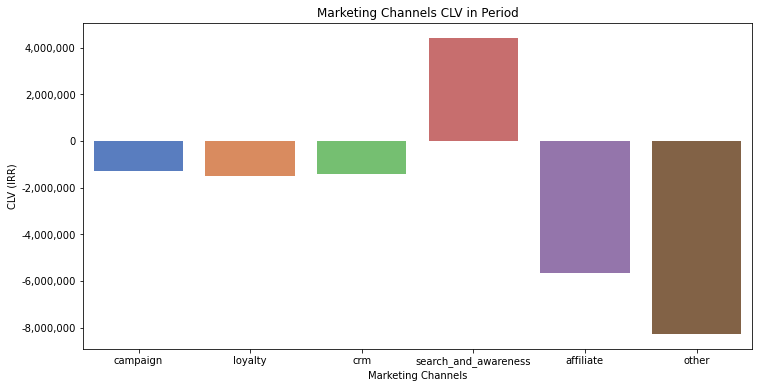

In [19]:
clv_calculations(df_flight, flight_financial, flight_lrfm,6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker

In [14]:
path= r"D:\python_scripts\promotion_analysis_project\dom_flight"

flight_lrfm= pd.read_csv(path + '\\' +'flight_lrfm.csv',
                         dtype={
                            'Mobile' : str
                         }).rename(columns={
                                 'Mobile' : 'mobile'
                         })
flight_lrfm['mobile']= flight_lrfm['mobile'].str[-10:]


flight_financial= pd.read_csv(path + '\\' + 'flight_financial.csv',
                              dtype= {'Mobile' : str}
                              ).rename(columns={'Mobile' : 'mobile'})
flight_financial.fillna(0, inplace= True)
flight_financial['mobile']= flight_financial['mobile'].str[-10:]
flight_financial['net_commission']=(
                                    flight_financial['Sum of Commission New']\
                                      + flight_financial['Sum of Markup Vat Excluded']\
                                        - flight_financial['Sum of Discount Per Ticket']\
                                          - flight_financial['Sum of Dump Amount'])

flight_table= pd.merge(left= flight_lrfm, right= flight_financial, on= 'mobile', how= 'left')

In [21]:
new_flight_table= flight_table[flight_table['Frequency'] > 1]

### date until 31 Mar
### Channels: Affiliate, Search, Loyalty, CRM, Campaign, other

In [36]:
pivot_table= new_flight_table.pivot_table(index= 'Merge Lrfm Level', values= ['net_commission', 'mobile', 'Frequency'], aggfunc= {'net_commission' : 'sum',
                                                                                                       'mobile' :  'count',
                                                                                                       'Frequency' : 'mean'})

In [83]:
### import dom. flight table and create needed dataframes

path= r"D:\python_scripts\promotion_analysis_project\intflight"
intflight= pd.read_csv(path + "\\" + "intflight.csv",
    parse_dates= ["booking_date"],
    dtype= {
    "phone_number": str,
    "refrence_no" : str,
    }
).rename(columns={
    'discount_name' : 'discount_code',
    'phone_number' : 'mobile',
    "refrence_no" : "invoiceID",
    "booking_date" : "date",
    "ticket_per_order" : "items",
    "is_new_user_total" : "new_vs_returning",
    "discount_code_tag" : "tag",
})
intflight= intflight[intflight['issue_state'] == 'SUCCESSFUL'].reset_index(drop= True)
intflight['mobile']= intflight['mobile'].str[-10:]
b2c_channels= intflight.channel.unique()
intflight= intflight[intflight["channel"].isin(b2c_channels)]
index= intflight[intflight["new_vs_returning"] == "New user in total"].index
intflight.loc[index, "new_vs_returning"]= "newUser"
index= intflight[intflight["new_vs_returning"] == "Returning in total"].index
intflight.loc[index, "new_vs_returning"]= "returningUser"

### creating a column for promotion channel types :Affiliate, Loyalty, CRM, Campaign

intflight= promotion_type(intflight)

<ipython-input-83-664e88873da9>:4: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  intflight= pd.read_csv(path + "\\" + "intflight.csv",


In [3]:
### import dom. flight table and create needed dataframes

path= r"D:\python_scripts\promotion_analysis_project\dom_hotel"
df_hotel= pd.read_csv(path + "\\" + "domhotel.csv",
    parse_dates= ["Registered Date"],
    dtype= {
    "Mobile": str,
    "Booking ID" : str,
    }
).rename(columns={
    'Discount Code' : 'discount_code',
    'Mobile' : 'mobile',
    "Booking ID" : "invoiceID",
    "Registered Date" : "date",
    "Room Nights" : "items",
    "New Or Returning User" : "new_vs_returning",
    "Tag" : "tag",
    'Utm Campaign' : 'utm_campaign'
})
df_hotel['mobile']= df_hotel['mobile'].str[-10:]
b2c_channels= df_hotel[~(df_hotel['Channel'].str.contains('b2b', case= False, na= False)) &\
                        ~(df_hotel['Channel'].str.match('AP')) & ~(df_hotel['Channel'].str.contains('telesales', case= False, na= False))]['Channel'].unique()
df_hotel= df_hotel[df_hotel["Channel"].isin(b2c_channels)]
index= df_hotel[df_hotel["new_vs_returning"] == "New User"].index
df_hotel.loc[index, "new_vs_returning"]= "newUser"
index= df_hotel[df_hotel["new_vs_returning"] == "Returning User"].index
df_hotel.loc[index, "new_vs_returning"]= "returningUser"

### creating a column for promotion channel types :Affiliate, Loyalty, CRM, Campaign

df_hotel= promotion_type(df_hotel)

In [4]:
domHotel_affiliate_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "affiliate"], "W")
domHotel_loyalty_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "loyalty"], "W")
domHotel_crm_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "crm"], "W")
domHotel_campaign_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "campaign"], "W")
domHotel_adwords_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "adwords"], "W")
domHotel_awareness_newReturning_users= new_vs_returning_users(df_hotel[df_hotel["marketing_channel"] == "organic"], "W")

domHotel_affiliate_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "affiliate"], "W")
domHotel_loyalty_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "loyalty"], "W")
domHotel_crm_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "crm"], "W")
domHotel_campaign_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "campaign"], "W")
domHotel_adwords_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "adwords"], "W")
domHotel_awareness_newReturning_orders= new_vs_returning_orders(df_hotel[df_hotel["marketing_channel"] == "organic"], "W")

In [5]:
domHotel_adwords_newReturning_orders

new_vs_returning,newUser,returningUser,total
date,,,
2023-02-05,200.0,208.0,408.0
2023-02-12,297.0,311.0,608.0
2023-02-19,365.0,406.0,771.0
2023-02-26,446.0,546.0,992.0
2023-03-05,573.0,605.0,1178.0
2023-03-12,510.0,477.0,987.0
2023-03-19,420.0,337.0,757.0
2023-03-26,200.0,144.0,344.0
2023-04-02,233.0,170.0,403.0


In [7]:
share_pivot(domHotel_awareness_newReturning_orders)[['newUser', 'returningUser']]

new_vs_returning,newUser,returningUser
date,,
2023-02-05,0.385313,0.614687
2023-02-12,0.358982,0.641018
2023-02-19,0.345723,0.654277
2023-02-26,0.370012,0.629988
2023-03-05,0.358532,0.641468
2023-03-12,0.367307,0.632693
2023-03-19,0.376751,0.623249
2023-03-26,0.439349,0.560651
2023-04-02,0.437020,0.562980


In [18]:
domHotel_adwords_newReturning_orders

new_vs_returning,newUser,returningUser,total
date,,,
2023-02-05,200.0,208.0,408.0
2023-02-12,297.0,311.0,608.0
2023-02-19,365.0,406.0,771.0
2023-02-26,446.0,546.0,992.0
2023-03-05,573.0,605.0,1178.0
2023-03-12,510.0,477.0,987.0
2023-03-19,420.0,337.0,757.0
2023-03-26,200.0,144.0,344.0
2023-04-02,233.0,170.0,403.0
